# I certify that the code and data in this assignment were generated independently, using only the tools and resources defined in the course and that I/we did not receive any external help, coaching or contributions during the production of this work.

In [2]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import torch
from torch import nn,optim
import torch.nn.functional as F
import torchvision.transforms as T
from collections import deque
import random
from IPython.display import clear_output

In [3]:
class GridEnvironment(gym.Env):
    
    def __init__(self,stochastic=False):
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 10
        self.timestep = 0
        self.done = False
        self.stochastic = stochastic
        self.pos = {'knight':[3,0],
                   'mon1':[1,2],
                   'mon2':[2,1],
                   'chest':[0,3],
                   'coin1':[3,1],
                   'coin2':[1,3]}
        
        self.mon1_death = False
        self.mon2_death = False
        self.coin1_collected = False
        self.coin2_collected = False
        
        # loading assets for rendering
        
        chars = mpimg.imread('Dungeon_Character.png')
        tiles = mpimg.imread('Dungeon_Tileset.png')
        assets = {}
        assets['knight'] = chars[:16,16*5:16*6]
        assets['mon1'] = chars[16:,16*6:]
        assets['mon2'] = chars[16:,16*5:16*6]
        assets['chest'] = tiles[16*8:16*9,16*4:16*5]
        assets['bones'] = tiles[16*7:16*8,16*7:16*8]
        torch = tiles[16*9:,:16]
        assets['coin1'] = tiles[16*8:16*9,16*6:16*7]
        assets['coin2'] = assets['coin1']
        stage = np.concatenate((tiles[:16*3,:16*6],
                                np.flip(tiles[16*2:16*3,:16*6],axis=1),
                                tiles[16*3:16*5,:16*6]),axis=0)
        stage[:16,16:16*2] = np.where(torch != 0,torch,stage[:16,16:16*2])
        stage[:16,16*4:16*5] = np.where(torch != 0,torch,stage[:16,16*4:16*5])
        self.stage = stage
        self.assets = assets
        self.archives = [tuple(self.pos['knight']+[self.mon1_death,self.mon2_death,self.coin1_collected,self.coin2_collected,self.timestep,0])]
        
    # used to archive the environment based on timesteps to render later
    def archive(self,reward):
        instance = tuple(self.pos['knight']+[self.mon1_death,self.mon2_death,self.coin1_collected,self.coin2_collected,self.timestep,reward])
        self.archives.append(instance)

    def reset(self):
        self.timestep = 0
        self.pos = {'knight':[3,0],
                   'mon1':[1,2],
                   'mon2':[2,1],
                   'chest':[0,3],
                   'coin1':[3,1],
                   'coin2':[1,3]}
        
        self.mon1_death = False
        self.mon2_death = False
        self.coin1_collected = False
        self.coin2_collected = False
        
        self.archives = [tuple(self.pos['knight']+[self.mon1_death,self.mon2_death,self.coin1_collected,self.coin2_collected,self.timestep,0])]
        self.done = False
        
    
    def step(self, action):
        '''
        0 - up
        1 - down
        2 - right
        3 - left
        '''
        if self.stochastic == True:
            action_prop = 0.9
            props = [0.025,0.025,0.025,0.025]
            props[action] += action_prop
            action = np.random.choice(4, 1, p=props)[0]
            
        if action == 0:
            self.pos['knight'][0] += 1
        elif action == 1:
            self.pos['knight'][0] -= 1
        elif action == 2:
            self.pos['knight'][1] += 1
        elif action == 3:
            self.pos['knight'][1] -= 1

        self.pos['knight'] = list(np.clip(self.pos['knight'], 0, 3))
        
        
        reward = 0
        if self.pos['knight'] == self.pos['chest']:
            reward = 10
            self.done = True
            
        elif self.pos['knight'] == self.pos['mon1']:
            if self.mon1_death:
                pass
            else:
                reward = -10
                self.mon1_death = True
                
        elif self.pos['knight'] == self.pos['mon2']:
            if self.mon2_death:
                pass
            else:
                reward = -10
                self.mon2_death = True
        elif self.pos['knight'] == self.pos['coin1']:
            if self.coin1_collected:
                pass
            else:
                reward = 2
                self.coin1_collected = True
        elif self.pos['knight'] == self.pos['coin2']:
            if self.coin2_collected:
                pass
            else:
                reward = 2
                self.coin2_collected = True
        
        self.timestep += 1
        if self.timestep == self.max_timesteps:
            self.done = True
        self.archive(reward)
        
        return reward
    
    # function used to construct the graphical interface of the environment using overlap an various other methods
    def project(self,archive_pos):
        instance = np.copy(self.stage)
        for item in ['mon1','mon2','chest','coin1','coin2']:
            item_asset = item
            if item == 'mon1' and archive_pos[2]:
                item_asset = 'bones'
            elif item == 'mon2' and archive_pos[3]:
                item_asset = 'bones'
            elif item == 'coin1' and archive_pos[4]:
                continue
            elif item == 'coin2' and archive_pos[5]:
                continue
            x = np.where(self.assets[item_asset] != 0, self.assets[item_asset], 
                       instance[16*(self.pos[item][0]+1):16*(self.pos[item][0]+2),
                                16*(self.pos[item][1]+1):16*(self.pos[item][1]+2)])
            instance[16*(self.pos[item][0]+1):16*(self.pos[item][0]+2),
                     16*(self.pos[item][1]+1):16*(self.pos[item][1]+2)] = x
            
        x = np.where(self.assets['knight'] != 0, self.assets['knight'], 
                    instance[16*(archive_pos[0]+1):16*(archive_pos[0]+2),
                            16*(archive_pos[1]+1):16*(archive_pos[1]+2)])
        instance[16*(archive_pos[0]+1):16*(archive_pos[0]+2),
                    16*(archive_pos[1]+1):16*(archive_pos[1]+2)] = x
        return instance
    
    def render(self):
        for instance in self.archives:
            envrironment = self.project(instance)
            plt.figure()
            plt.axis('off')
            plt.text(0,93,'timestep:'+str(instance[6])+'   reward:'+str(instance[7]),fontsize = 14,color = 'w')
            plt.imshow(envrironment,interpolation='none',aspect='equal')
            
    def get_state(self):
        out = np.zeros((4,4,4))
        out[0][tuple(grid.pos['knight'])] = 1
        if not self.coin1_collected:
            out[1][tuple(grid.pos['coin1'])] = 1
        if not self.coin2_collected:
            out[1][tuple(grid.pos['coin2'])] = 1
        if not self.mon1_death:
            out[2][tuple(grid.pos['mon1'])] = 1
        if not self.mon2_death:
            out[2][tuple(grid.pos['mon2'])] = 1
        out[3][tuple(grid.pos['chest'])] = 1
        return out.flatten()
        
        

In [4]:
class DQN(nn.Module):
    def __init__(self,length):
        super().__init__()
        self.fc1 = nn.Linear(64,256)
        self.fc2 = nn.Linear(256,64)
        self.out = nn.Linear(64,4)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [5]:
class Replay:
    def __init__(self,mem_size,sample_size):
        self.mem_size = mem_size
        self.sample_size = sample_size
        self.queue =deque(maxlen=mem_size)
        
    def push(self,x):
        self.queue.append(x)
        
    def sample(self):
        return random.sample(self.queue,self.sample_size)
    
    def samplable(self):
        return len(self.queue) > self.sample_size

In [6]:
class Decay:
    def __init__(self,start,end,decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_ep_rate(self,timestep):
        return self.end + (self.start - self.end) * np.exp(-1 * timestep * self.decay)

In [7]:
class Agent:
    def __init__(self,decay,num_actions):
        self.decay = decay
        self.num_actions = num_actions
        self.timestep = 0
        
    def select_action(self,state,policy):
        rate = self.decay.get_ep_rate(self.timestep)
        self.timestep += 1
        
        if rate > random.random():
            return random.randrange(self.num_actions),rate
        else:
            with torch.no_grad():
                return policy(state).argmax().item(),rate

In [8]:
def extract(instances):
    states = []
    next_states = []
    rewards = []
    actions = []
    dones = []
    for state,action,reward,next_state,done in instances:
        states.append(state)
        next_states.append(next_state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)
    return torch.tensor(np.array(states),dtype=torch.float32),\
           torch.tensor(actions,dtype=torch.float32), \
           torch.tensor(rewards,dtype=torch.float32), \
           torch.tensor(np.array(next_states),dtype=torch.float32), \
           dones

In [9]:
def get_predict(rewards,discount,next_states,dones,target,actions,current_qs):
    vals = []
    next_qs = target(next_states)
    for reward,next_q,done in zip(rewards,next_qs,dones):
        if done:
            vals.append(reward)
        else:
            vals.append(reward + discount * max(next_q))
    
    out = []
    current_qs = current_qs.clone().detach().numpy()
    for current_q,action,val in zip(current_qs,actions,vals):
        current_q[int(action)] = val
        out.append(current_q)
    return torch.tensor(np.array(out))       

In [28]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [69]:
min_er = 0.01
max_er = 1
decay_er = 0.001
episodes = 1000
discount = 0.8
update_target = 10

In [70]:
grid = GridEnvironment(stochastic=True)
decay = Decay(max_er,min_er,decay_er)
agent = Agent(decay,4)
memory = Replay(10000,256)
policy = DQN(64)
target = DQN(64)
target.load_state_dict(policy.state_dict())
target.eval()
optimizer = optim.Adam(params=policy.parameters(),lr=0.001)


In [71]:
reward_per_episode = []
epsilon_data = []
for episode in range(episodes):
    grid.reset()
    state = grid.get_state()
    episode_reward = 0
    while not grid.done:
        action,rate = agent.select_action(torch.tensor(state,dtype=torch.float32),policy)
        reward = grid.step(action)
        
        epsilon_data.append(rate)
        episode_reward += reward
        
        next_state = grid.get_state()
        memory.push([state,action,reward,next_state,grid.done])
        state = next_state

        if memory.samplable():
            instances = memory.sample()
            states, actions, rewards, next_states, dones = extract(instances)
            
            current_qs = policy(states)
            predict = get_predict(rewards,discount,next_states,dones,target,actions,current_qs)
            
            loss = F.mse_loss(predict,current_qs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    if episode % update_target == 0:
        target.load_state_dict(policy.state_dict())
    reward_per_episode.append(episode_reward)
    
    completion = int((episode/episodes)*100)
    bar = '='*completion + ' '*(100-completion)
    print(f"{completion+1}%"+'['+bar+']')
    clear_output(wait=True)

99%[=================================================================================================== ]


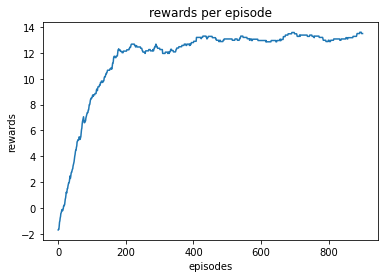

In [88]:
plt.plot(running_mean(reward_per_episode,100))
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.title('rewards per episode')
plt.savefig('results/rperepisode.png',dpi=300)

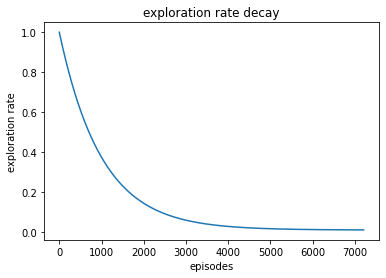

In [89]:
plt.plot(epsilon_data)
plt.xlabel('episodes')
plt.ylabel('exploration rate')
plt.title('exploration rate decay')
plt.savefig('results/expdecay.png',dpi=300)

In [93]:
no_evaluation_episodes = 100
grid = GridEnvironment(stochastic=True)
rewards_per_episode = []
for episode in range(no_evaluation_episodes):
    grid.reset()
    total_reward = 0
    state = torch.tensor(grid.get_state(),dtype=torch.float32)
    while not grid.done:
        action = policy(state).argmax().item()
        reward = grid.step(action)
        total_reward += reward
        state = torch.tensor(grid.get_state(),dtype=torch.float32)
    rewards_per_episode.append(total_reward)

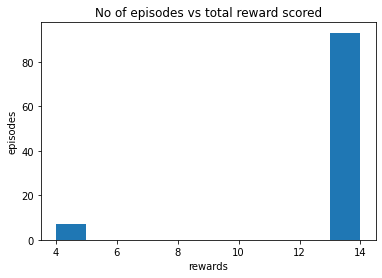

In [96]:
_ = plt.hist(rewards_per_episode)
plt.xlabel('rewards')
plt.ylabel('episodes')
plt.title('No of episodes vs total reward scored')
plt.savefig('results/evaluation.png',dpi=300)